In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from functools import partial
from matplotlib import cm
from scipy import signal
import cv2
from tkinter import Tk
from tkinter.filedialog import askdirectory
import os
from helper import Zica, Zica_2, Slika
from analiza import main_single
import scipy
import json
import analiza

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Computer Modern Roman",
})
plt.rcParams.update({
    'errorbar.capsize' : 10
})
plt.rcParams.update({'font.size' : 40, 'figure.figsize' : (10, 7), 'lines.linewidth' : 4,
    'lines.markersize' : 9, 'grid.linestyle' : '--', 'axes.grid' : True})
params= {'text.latex.preamble' : r'\usepackage{amsmath,amsfonts,amssymb,amsthm,siunitx}'}
plt.rcParams.update(params)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def calculateField(amplitude=1., direction='x'):
    """ Calculate the amplitude of the magnetic field in mT
    generated by the coils

    :param amplitude: Set amplitude
    :param direction:
    :return: magnetic field in milli tesla
    """

    field = 10 * amplitude  # for z direction B = 10 mT/A * I
    if direction in ['x', 'y']:
        field /= 5.7

    return field

def f_min(x, *args):
    Bx, By, I_ = args[0], args[1], args[2]
    k, n1, n2 = x[0], x[1], x[2]

    f1 = lambda bx: k*bx + n1
    f2 = lambda bx: -1/k*bx + n2
    y1 = f1(Bx)
    y2 = f2(Bx)

    f = np.stack(((y1 - By)**2, (y2 - By)**2), axis=-1)*I_[:, :, None]
    f = np.amin(f, axis=2)
    
    return np.sum(f)

In [48]:
root = Tk()
root.update() 

path = askdirectory(title='Select Folder')
root.destroy()

if os.path.exists(path + "/results.json"):
    with open(path + "/results.json", "r") as f:
        results = json.loads(f.read())

    B0 = results["B0"]
    I = results["I"]
else:
    with open(path + "/properties.json", "r") as f:
        properties = json.loads(f.read())

    N = int(properties["N"])
    Ix_off = float(properties["Ix_off"])
    Iy_off = float(properties["Iy_off"])

    try:
        B0, I, _ = analiza.extract2(path)
    except KeyError:
        B0, I = analiza.extract(path)

    results = {"B0" : B0, "I" : I}

B0 = np.array(B0)
I = np.array(I)

ind = np.lexsort((I, B0[:, 0], B0[:, 1]))

sorted = np.hstack((B0[:, 1][:, None], B0[:, 0][:, None], I[:, None]))[ind].reshape((N, N, 3))

Bx, By, I_ = sorted[:, :, 1], sorted[:, :, 0], sorted[:, :, 2]

# fig, ax = plt.subplots(figsize=(12, 12))

# ax.pcolor(Bx, By, I_)
# ax.grid(False)

# plt.show()

# --------------------

I_ /= np.amax(I_)
mask = I_ > 0.1
I_[mask] = 0
I_[~mask] = 1

res = scipy.optimize.minimize(f_min, [1. ,1., 1.], (Bx, By, I_))
print(res.message)

k, n1, n2 = res.x[0], res.x[1], res.x[2]

x0 = (n2 - n1) / (k + 1/k)
y0 = k*x0 + n1
x0 = -x0
y0 = -y0

print("x0 = {:.2f}, y0 = {:.2f}".format(x0, y0))
print("\nMeasured values:")
print("B_mag = {:.2f} uT, phi = {:.2f} deg".format(np.sqrt(x0**2 + y0**2), 
                                                   np.arctan2(y0, x0)*180/np.pi))
Bx_off = calculateField(Ix_off, "x")
By_off = calculateField(Iy_off, "y")

# print("\nActual values:")
# print("B_mag = {:.2f} uT, phi = {:.2f} deg".format(np.sqrt(Bx_off**2 + By_off**2)*1000,
#                                             np.arctan2(By_off, Bx_off)*180/np.pi))

# --------------------

# x = np.linspace(np.amin(Bx), np.amax(Bx), 3)

# fig, ax = plt.subplots(figsize=(12, 12))

# ax.grid(False)
# ax.pcolor(Bx, By, I_)
# ax.plot(x, k*x + n1, color="red")
# ax.plot(x, -1/k*x + n2, color="red")

# ax.set_ylim((np.amin(By), np.amax(By)))

# plt.show()

with open(path + "/results.json", "w") as f:
    f.write(json.dumps(results))

x0_out = x0
y0_out = y0

Desired error not necessarily achieved due to precision loss.
x0 = 87.11, y0 = -13.46

Measured values:
B_mag = 88.14 uT, phi = -8.79 deg


In [51]:
root = Tk()
root.update() 

path = askdirectory(title='Select Folder')
root.destroy()

if os.path.exists(path + "/results.json"):
    with open(path + "/results.json", "r") as f:
        results = json.loads(f.read())

    B0 = results["B0"]
    I = results["I"]
else:
    with open(path + "/properties.json", "r") as f:
        properties = json.loads(f.read())

    N = int(properties["N"])
    Ix_off = float(properties["Ix_off"])
    Iy_off = float(properties["Iy_off"])

    try:
        B0, I, _ = analiza.extract2(path)
    except KeyError:
        B0, I = analiza.extract(path)

    results = {"B0" : B0, "I" : I}

B0 = np.array(B0)
I = np.array(I)

ind = np.lexsort((I, B0[:, 0], B0[:, 1]))

sorted = np.hstack((B0[:, 1][:, None], B0[:, 0][:, None], I[:, None]))[ind].reshape((N, N, 3))

Bx, By, I_ = sorted[:, :, 1], sorted[:, :, 0], sorted[:, :, 2]

# fig, ax = plt.subplots(figsize=(12, 12))

# ax.pcolor(Bx, By, I_)
# ax.grid(False)

# plt.show()

# --------------------

I_ /= np.amax(I_)
mask = I_ > 0.1
I_[mask] = 0
I_[~mask] = 1

res = scipy.optimize.minimize(f_min, [1. ,1., 1.], (Bx, By, I_))
print(res.message)

k, n1, n2 = res.x[0], res.x[1], res.x[2]

x0 = (n2 - n1) / (k + 1/k)
y0 = k*x0 + n1
x0 = -x0 - x0_out
y0 = -y0 - y0_out

print("x0 = {:.2f}, y0 = {:.2f}".format(x0, y0))
print("\nMeasured values:")
print("B_mag = {:.2f} uT, phi = {:.2f} deg".format(np.sqrt(x0**2 + y0**2), 
                                                   np.arctan2(y0, x0)*180/np.pi))
Bx_off = calculateField(Ix_off, "x")
By_off = calculateField(Iy_off, "y")

print("\nActual values:")
print("B_mag = {:.2f} uT, phi = {:.2f} deg".format(np.sqrt(Bx_off**2 + By_off**2)*1000,
                                            np.arctan2(By_off, Bx_off)*180/np.pi))

# --------------------

# x = np.linspace(np.amin(Bx), np.amax(Bx), 3)

# fig, ax = plt.subplots(figsize=(12, 12))

# ax.grid(False)
# ax.pcolor(Bx, By, I_)
# ax.plot(x, k*x + n1, color="red")
# ax.plot(x, -1/k*x + n2, color="red")

# ax.set_ylim((np.amin(By), np.amax(By)))

# plt.show()

with open(path + "/results.json", "w") as f:
    f.write(json.dumps(results))

Desired error not necessarily achieved due to precision loss.
x0 = 214.60, y0 = 551.91

Measured values:
B_mag = 592.16 uT, phi = 68.75 deg

Actual values:
B_mag = 632.55 uT, phi = 70.56 deg


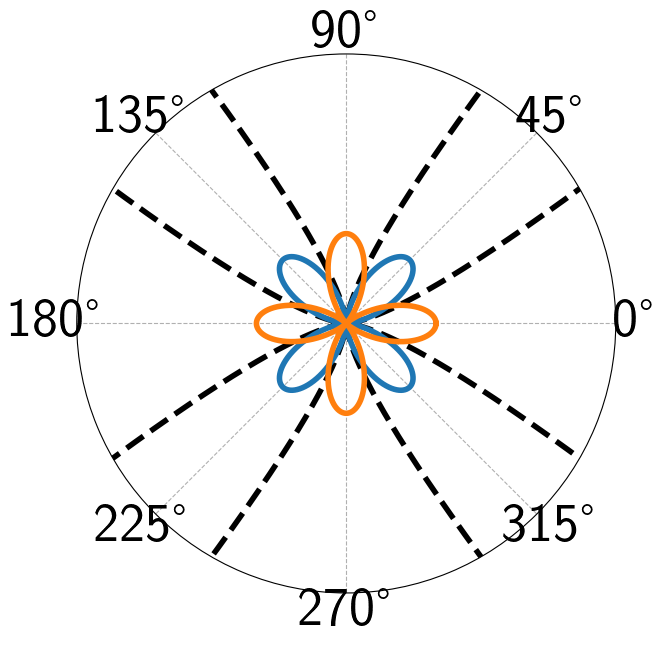

In [63]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

theta = np.linspace(0, 2*np.pi, 10000)
y2 = np.cos(2*theta)**2
y1 = np.sin(2*theta)**2

mask = (y2 != 0)
ax.plot(theta[mask], y1[mask]/y2[mask], color="black", ls="--")

ax.plot(theta, y1)
ax.plot(theta, y2)

ax.set_rticks([])  # Less radial ticks
ax.set_rlim((0, 3))

plt.show()